In [6]:
!nvidia-smi

Tue Apr 27 14:11:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.33       Driver Version: 461.33       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro T2000 wi... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8     1W /  N/A |   2453MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import gc
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers import Activation
from IPython.display import display
from keras.utils import plot_model

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

In [8]:
tf.random.set_seed(207241)
np.random.seed(207241)

In [9]:
#Read data from hdf5 file
import numpy as np
import h5py

def loadDataH5():        
    with h5py.File('C:\\gyani\\DL\\assignment\\earth_data\\earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))        
    return trainX, trainY, valX, valY

In [10]:
#Get All details about data
def get_working_data():
  trainX, trainY, valX, valY = loadDataH5()
  training_data_count,height,width,depth = trainX.shape
  unique_val, class_dist = np.unique(trainY,return_counts=True)
  print("Number of classes:",unique_val.shape[0])
  print("Class Value:",unique_val)
  print("Class distribution:",class_dist)
  print(trainX.shape,trainY.shape)
  print(valX.shape,valY.shape)
  trainX = trainX.astype("float") / 255.0
  valX = valX.astype("float") / 255.0
  return trainX, trainY, valX, valY,(height,width,depth,unique_val.shape[0])

g_trainX,g_trainY,g_valX,g_valY,(g_height,g_width,g_depth,g_classes) = \
                        get_working_data()

Number of classes: 9
Class Value: [0 1 2 3 4 5 6 7 8]
Class distribution: [2400 2400 2400 2000 2000 1600 2000 2400 2000]
(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


In [11]:
#Stores the performance matrix for each model run
class MODEL_PERFORMANCE:

  def __init__(self, model_part,val_acc):
    self.model_part = model_part
    self.val_acc  = val_acc    


class RECORD:

  def __init__(self):
    self.store = {}    

  def add_entry(self,name,performance):
    if name not in self.store:
      self.store[name] = []
    self.store[name].append(performance)

#Global object 
g_record_v1 = RECORD()

In [12]:
def get_high_level_model(trained_model_name,inputshape):
  model = None
  if trained_model_name == "vgg16":
      model = tf.keras.applications.VGG16(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
      
  elif trained_model_name == "vgg19":
      model =  tf.keras.applications.VGG19(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
      
  elif trained_model_name == "resnet50":
     model = tf.keras.applications.ResNet50(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
     
  elif trained_model_name == "densenet121":
     model = tf.keras.applications.DenseNet121(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
     
  elif trained_model_name == "densenet169":
     model = tf.keras.applications.DenseNet169(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
  
  if model != None:
    model.trainable = False

  return model

In [13]:
# Performance plot for a model depicting training/validation loss/accuracy

def plot_model_performance(history,model_name,part):
  plt.style.use("ggplot")
  plt.figure()
  epoch_ran = len(history.history["loss"])
  plt.plot(np.arange(0, epoch_ran), \
           history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

  #Print best score 
  print("Model Performance Summary:")
  best_val_accuracy = max(history.history["val_accuracy"])
  print("Best Validation Accuracy: ",best_val_accuracy," at EPOCH:",\
        history.history["val_accuracy"].index(best_val_accuracy))
  
  min_val_loss = min(history.history["val_loss"])
  print("Min validation loss:",min_val_loss," at EPOCH:", \
        history.history["val_loss"].index(min_val_loss))
  
  #Store the above performance matrix
  g_record_v1.add_entry(model_name,MODEL_PERFORMANCE(model_part = part, \
     val_acc = best_val_accuracy))

In [14]:
def plot_summary(name):
  data = []  
  perf = g_record_v1.store[name]
  for it in perf:
    data.append([it.model_part,it.val_acc])

  df = pd.DataFrame(data, columns = ['Stage', 'Accuracy'])
  display(df)
  plt.figure()
  plot = sns.barplot(y='Stage', x='Accuracy', data=df)
  plt.show()

In [15]:
def get_early_stoping_cb_on_min_val_loss(patience_num = 4):
  return EarlyStopping(monitor='val_loss', mode='min', verbose=1, \
                       patience=patience_num)

def get_model_checkpoint_cb_on_min_val_loss(file_name):
  return ModelCheckpoint(file_name, monitor="val_loss", 	mode="min", \
                         save_best_only=True, verbose=1)	

def learning_rate_schedular_fun(epoch, lr):
  if epoch <10:
    return lr 
  else:
    return lr*tf.math.exp(-.1)
  
def get_model_learning_rate_cb():
  return tf.keras.callbacks.LearningRateScheduler(learning_rate_schedular_fun,\
                                                  verbose=1)


def get_basic_callback():
  return [get_early_stoping_cb_on_min_val_loss()]

def get_basic_and_lrs_callback():
  return [get_early_stoping_cb_on_min_val_loss(),get_model_learning_rate_cb()]

def get_all_callback(file_name):
  return [get_early_stoping_cb_on_min_val_loss(),\
          get_model_checkpoint_cb_on_min_val_loss(file_name),
          get_model_learning_rate_cb()]

In [16]:
NUM_EPOCHS = 50
BATCH_SIZE = 32
class HIGH_LEVEL_MODEL:
  def __init__(self, trained_model_name, inputshape = (64,64,3)):

    self.model = tf.keras.models.Sequential(name = trained_model_name)
    self.high_level_model_obj = get_high_level_model(trained_model_name, \
                                                     inputshape)
    self.model.add(self.high_level_model_obj)
    self.model.add(tf.keras.layers.Flatten())
    self.model.add(tf.keras.layers.Dropout(0.2))
    self.model.add(tf.keras.layers.Dense(256, activation='relu'))  
    self.model.add(tf.keras.layers.Dense(g_classes, activation='sigmoid'))                             
    
    print(self.model.summary())    
    display(plot_model(self.model, show_shapes=True, expand_nested=True))
    self.features_train = self.model.predict(g_trainX)
    self.features_val = self.model.predict(g_valX)

    self.features_train = self.features_train.reshape \
                                  (self.features_train.shape[0], -1)
    self.features_val = self.features_val.reshape   \
                                  (self.features_val.shape[0], -1)

    self.model_file_name = self.model.name+".json"
    self.model_wt_file_name = self.model.name+".hdf5"

    print("Train Feature Shape:",self.features_train.shape)
    print("Val Feature Shape:",self.features_val.shape)



  def phase_a(self,train_x = g_trainX,train_y=g_trainY,val_x = g_valX,val_y=g_valY):
    print ("\n Phase A - Training Fully Connected Layers\n")
    
    self.model.compile(loss='sparse_categorical_crossentropy', \
          optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),metrics=['accuracy'])
    
    model_json = self.model.to_json()
    with open(self.model_file_name, "w") as json_file:
      json_file.write(model_json)

    history = self.model.fit(train_x, train_y, epochs=NUM_EPOCHS, \
                   batch_size=BATCH_SIZE, validation_data=(val_x, val_y), \
                   callbacks = get_all_callback(self.model_wt_file_name))
    
    plot_model_performance(history,self.model.name,"phase_a")
  


  def phase_b(self,trainable_layer,train_x = g_trainX,train_y=g_trainY,val_x = g_valX,val_y = g_valY):
    print ("\n Phase B  - Fine Tune Fully Connected Layer and \
                Selected Convolutional Layers \n")
    
    self.model.load_weights(self.model_wt_file_name)


    self.high_level_model_obj.trainable = True
    trainableFlag = False
    
    for layer in self.high_level_model_obj.layers:
        
      if layer.name == trainable_layer:
          trainableFlag = True
            
      layer.trainable = trainableFlag
    
    self.model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
                metrics=['accuracy'])
    
    history = self.model.fit(train_x, train_y, epochs=NUM_EPOCHS, \
                  batch_size=BATCH_SIZE, validation_data = (val_x, val_y), \
                  callbacks = get_all_callback(self.model_wt_file_name))
    
    plot_model_performance(history,self.model.name,"phase_b")

  def phase_c(self,train_x = g_trainX,train_y=g_trainY,val_x = g_valX,val_y=g_valY):

    print("\n Phase C  - Apply data augmentation \n")

    data_generator_full = tf.keras.preprocessing.image.ImageDataGenerator( \
                          shear_range=0.2, 
                          zoom_range=0.2,
                          rotation_range=10,   
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          horizontal_flip=True,
                          vertical_flip=True)
    
    train_generator_full = data_generator_full.flow(g_trainX, \
                                  g_trainY, batch_size=BATCH_SIZE)
     
    self.model.load_weights(self.model_wt_file_name)
    #self.high_level_model_obj.trainable = False

    self.model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5), \
                      loss='sparse_categorical_crossentropy', \
                      metrics=['accuracy'])
    
    history = self.model.fit(train_generator_full, epochs = NUM_EPOCHS,  \
                            validation_data= (g_valX,g_valY), \
                      steps_per_epoch=len(g_trainX)/ BATCH_SIZE, \
                      callbacks = get_all_callback(self.model_wt_file_name))    
    
    plot_model_performance(history,self.model.name,"phase_c")



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 2313      
Total params: 15,241,545
Trainable params: 526,857
Non-trainable params: 14,714,688
_________________________________________________________________
None


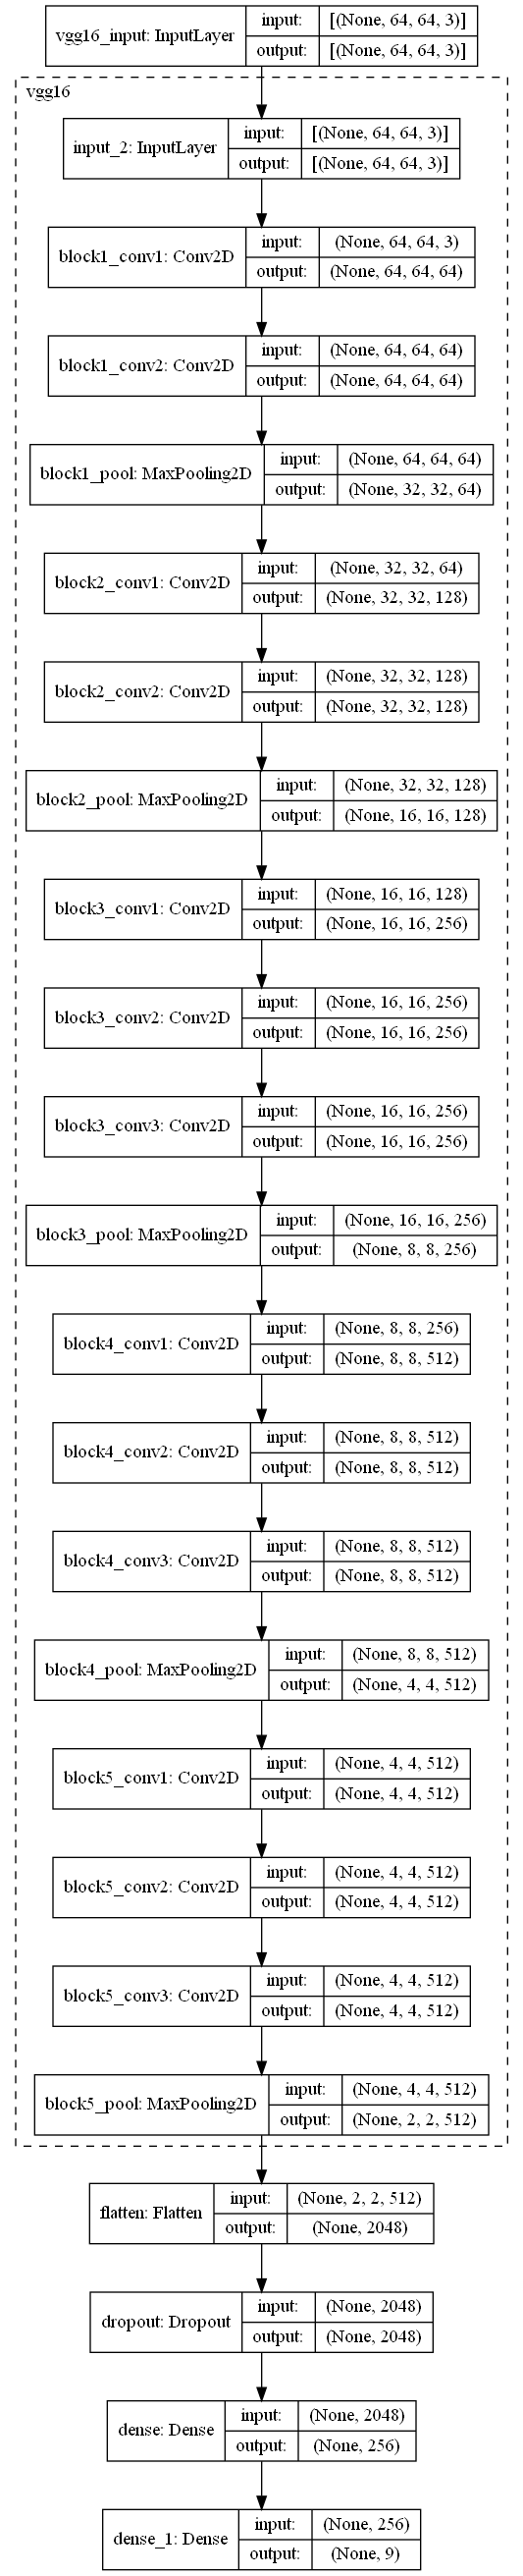

Train Feature Shape: (19200, 9)
Val Feature Shape: (4800, 9)

 Phase A - Training Fully Connected Layers

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
600/600 [==============================] - 21s 34ms/step - loss: 0.9138 - accuracy: 0.6783 - val_loss: 0.5395 - val_accuracy: 0.8135

Epoch 00001: val_loss improved from inf to 0.53953, saving model to vgg16.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
600/600 [==============================] - 20s 33ms/step - loss: 0.5404 - accuracy: 0.8098 - val_loss: 0.5121 - val_accuracy: 0.8285

Epoch 00002: val_loss improved from 0.53953 to 0.51215, saving model to vgg16.hdf5
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
600/600 [==============================] - 20s 34ms/step - loss: 0.4752 - accuracy: 0.8316 - val_loss: 0.4495 - val_accuracy: 0.8525

Epoch 00003: val_loss improved from 0.5121

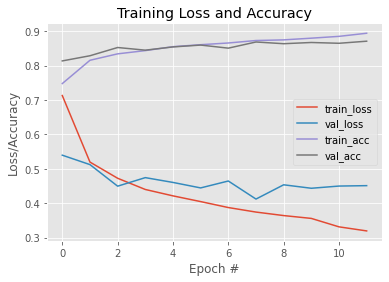

Model Performance Summary:
Best Validation Accuracy:  0.8708333373069763  at EPOCH: 11
Min validation loss: 0.4120069742202759  at EPOCH: 7


In [17]:
model_obj = HIGH_LEVEL_MODEL("vgg16")
model_obj.phase_a()


 Phase B  - Fine Tune Fully Connected Layer and                 Selected Convolutional Layers 

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
600/600 [==============================] - 45s 73ms/step - loss: 0.3573 - accuracy: 0.8808 - val_loss: 0.3066 - val_accuracy: 0.8981

Epoch 00001: val_loss improved from inf to 0.30661, saving model to vgg16.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
600/600 [==============================] - 43s 72ms/step - loss: 0.2238 - accuracy: 0.9247 - val_loss: 0.3594 - val_accuracy: 0.8946

Epoch 00002: val_loss did not improve from 0.30661
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
600/600 [==============================] - 43s 72ms/step - loss: 0.1664 - accuracy: 0.9460 - val_loss: 0.3174 - val_accuracy: 0.9098

Epoch 00003: val_loss did not improve from 0.30661
Epoch 4/50

Epoch 00004: Learnin

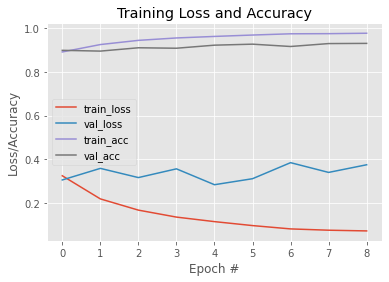

Model Performance Summary:
Best Validation Accuracy:  0.9297916889190674  at EPOCH: 8
Min validation loss: 0.2848776876926422  at EPOCH: 4


In [30]:
model_obj.phase_b("block5_conv1")


 Phase C  - Apply data augmentation 

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
600/600 [==============================] - 27s 44ms/step - loss: 0.8069 - accuracy: 0.8053 - val_loss: 0.2985 - val_accuracy: 0.9183

Epoch 00001: val_loss improved from inf to 0.29852, saving model to vgg16.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
600/600 [==============================] - 26s 43ms/step - loss: 0.5179 - accuracy: 0.8601 - val_loss: 0.3397 - val_accuracy: 0.9050

Epoch 00002: val_loss did not improve from 0.29852
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
600/600 [==============================] - 26s 43ms/step - loss: 0.4827 - accuracy: 0.8652 - val_loss: 0.3546 - val_accuracy: 0.8998

Epoch 00003: val_loss did not improve from 0.29852
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752

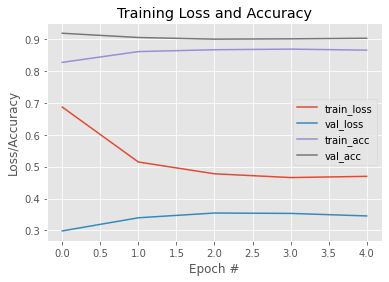

Model Performance Summary:
Best Validation Accuracy:  0.9183333516120911  at EPOCH: 0
Min validation loss: 0.29851701855659485  at EPOCH: 0


In [31]:
model_obj.phase_c(g_trainX,g_trainY,g_valX,g_valY)

In [1]:
plot_summary("vgg16")

NameError: name 'plot_summary' is not defined